In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

In [2]:
df = pd.read_csv(r"C:\Users\benak\Python_Base_Dir\data\rainfall\train.csv", index_col=0)
test_df = pd.read_csv(r"C:\Users\benak\Python_Base_Dir\data\rainfall\test.csv", index_col=0)
df.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [3]:
test_df.iloc[0]

day                 1.0
pressure         1019.5
maxtemp            17.5
temparature        15.8
mintemp            12.7
dewpoint           14.9
humidity           96.0
cloud              99.0
sunshine            0.0
winddirection      50.0
windspeed          24.3
Name: 2190, dtype: float64

## Scoping

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import HistGradientBoostingClassifier

In [5]:
def standardize(df, test_df):
    std_df, std_test_df = df.copy(), test_df.copy()
    for c in std_df.columns[1:-1]: std_df[c] = (std_df[c] - std_df[c].mean()) / std_df[c].std()
    for c in std_test_df.columns[1:]: std_test_df[c] = (std_test_df[c] - std_test_df[c].mean()) / std_test_df[c].std()
    return std_df, std_test_df

std_df, std_test_df = standardize(df, test_df)

# need non-random split since data is time series
def split(df, test_size=0.2):
    n = int((len(df) * (1 - test_size)))
    train = df.iloc[:n]
    test = df.iloc[n:]
    return train, test

In [6]:
tr, val = split(std_df)
Xtr, Ytr = tr.iloc[:, :-1], tr.iloc[:, -1]
Xval, Yval = val.iloc[:, :-1], val.iloc[:, -1]

lm = LogisticRegression(solver='newton-cg', max_iter=1000)
lm.fit(Xtr, Ytr)
Ypred = lm.predict(Xval)

print(f'train acc: {accuracy_score(Ytr, lm.predict(Xtr)):.4f}')
print(f'Val acc: {accuracy_score(Yval, Ypred):.4f}')
print(f'Val roc/auc: {roc_auc_score(Yval, Ypred)}')

train acc: 0.8682
Val acc: 0.8699
Val roc/auc: 0.7700113093742147


In [7]:
# try gradient boost on unstandardized data
tr, val = split(df)
Xtr, Ytr = tr.iloc[:, :-1], tr.iloc[:, -1]
Xval, Yval = val.iloc[:, :-1], val.iloc[:, -1]

hgb = HistGradientBoostingClassifier(max_iter=1000, max_depth=1, random_state=42)

hgb.fit(Xtr, Ytr)
Ypred = hgb.predict(Xval)

print(f'train acc: {accuracy_score(Ytr, hgb.predict(Xtr)):.4f}')
print(f'Val acc: {accuracy_score(Yval, Ypred):.4f}')
print(f'Val roc/auc: {roc_auc_score(Yval, Ypred)}')

train acc: 0.8910
Val acc: 0.8607
Val roc/auc: 0.7642309625534054


In [8]:
# cv tune hist gradient boosting classifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter': [1000],
    'max_depth': [1, 2, 3, 4, 5],
    'l2_regularization': [0.1, 0.01, 0.001],
    'learning_rate': [0.1, 0.01, 0.001]
}

hgb = HistGradientBoostingClassifier(random_state=42)
grid = GridSearchCV(hgb, param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(Xtr, Ytr)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)
Ypred = grid.best_estimator_.predict(Xval)

print(f'train acc: {accuracy_score(Ytr, grid.best_estimator_.predict(Xtr)):.4f}')
print(f'Val acc: {accuracy_score(Yval, Ypred):.4f}')
print(f'Val roc/auc: {roc_auc_score(Yval, Ypred)}')

Fitting 5 folds for each of 45 candidates, totalling 225 fits
{'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'max_iter': 1000}
0.8693072853072852
HistGradientBoostingClassifier(l2_regularization=0.1, learning_rate=0.01,
                               max_depth=1, max_iter=1000, random_state=42)
train acc: 0.8739
Val acc: 0.8699
Val roc/auc: 0.7819803970846946


### Hmmmmm

What will it take to do better than this?

Some possibilities:
1. There are time-dependent effects that aren't captured by the inherent seasonality of the `day` predictor.
    - May be worth exploring features constructed from recent days, or the predictors of recent days (like yesterday's `pressure`)
2. There are meaningful non-linear interactions between predictors that may be under-represented by the tree-based feature selection of the gradient boosting classifer. 
    - Could try to explore these with EDA and feature engineering - capturing a meaningful representation could be done with NNs but could get annoying...

It seems like I should be able to use an attention-based NN architecture to implicitly capture the temporal relationships between the predictors without needing to do any feature engineering... This would ideally address both possibilities (1) and (2) at once...

First, let's try a little feature engineering - add SMAs as features.

In [9]:
df_sma = df.copy()

# compute sma for each column
smas = [5, 10, 20, 50, 100]
for c in df.columns[1:-1]:
    for s in smas:
        df_sma[f'{c}_sma_{s}'] = df[c].rolling(s).mean()

df_sma.dropna(inplace=True)

In [10]:
# try gradient boost on sma data
features = [c for c in df_sma.columns if 'rainfall' not in c]
target = 'rainfall'
tr, val = split(df_sma)
Xtr, Ytr = tr.loc[:, features], tr.loc[:, target]
Xval, Yval = val.loc[:, features], val.loc[:, target]

param_grid = {
    'max_iter': [1000],
    'max_depth': [1, 2, 3, 4, 5],
    'l2_regularization': [0.1, 0.01, 0.001],
    'learning_rate': [0.1, 0.01, 0.001]
}

hgb = HistGradientBoostingClassifier(random_state=42)
grid = GridSearchCV(hgb, param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(Xtr, Ytr)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)
Ypred = grid.best_estimator_.predict(Xval)

print(f'train acc: {accuracy_score(Ytr, grid.best_estimator_.predict(Xtr)):.4f}')
print(f'Val acc: {accuracy_score(Yval, Ypred):.4f}')
print(f'Val roc/auc: {roc_auc_score(Yval, Ypred)}')

Fitting 5 folds for each of 45 candidates, totalling 225 fits
{'l2_regularization': 0.001, 'learning_rate': 0.01, 'max_depth': 4, 'max_iter': 1000}
0.8702386272231657
HistGradientBoostingClassifier(l2_regularization=0.001, learning_rate=0.01,
                               max_depth=4, max_iter=1000, random_state=42)
train acc: 0.9557
Val acc: 0.8687
Val roc/auc: 0.7880438578112997


Kinda surprising that this is only a tiny bit better... Although, the training accuracy is significantly better... hmm...

### Lil Transformer

We'll use `nn.TransformerEncoderLayer` to build a small classification transformer.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [12]:
# create dataloader compatible dataset
# need len method and getitem method for compatibility with DataLoader
class RainDataset(Dataset):
    def __init__(self, df, seq_len: int = 7, target: str = 'rainfall'):
        self.data = df
        self.seq_len = seq_len
        self.target_col = target
        self.feat_cols = [c for c in df.columns if c != target]

        self.indices = range(seq_len, len(df))  # indices for end of sequence

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        """Method for pytorch DataLoader compatibility. Return feature target pairs by index (idx)"""
        # start with end of sequence index
        idx = self.indices[idx]
        
        # get indices for all observations within the sequence
        seq_indices = range(idx - self.seq_len + 1, idx + 1)

        # get featers for each observation in the sequence
        features = torch.tensor(
            self.data.iloc[seq_indices][self.feat_cols].values,
            dtype=torch.float32
        )

        # get target for END OF SEQUENCE ONLY
        target = torch.tensor(
            self.data.iloc[idx][self.target_col],
            dtype=torch.float32
        )

        return features, target
        
# create dataloaders
train_ds = RainDataset(tr)
val_ds = RainDataset(val)

In [23]:
class RaiNN(nn.Module):
    def __init__(self, 
                 n_features,            # number of input features
                 d_model=64,            # dimension of encoder layer
                 nhead=8,               # number of heads in multiheadattention models
                 num_encoder_layers=6,  # number of encoder layers
                 dim_feedforward=128,   # dimension of feedforward network
                 dropout=0.1,           # dropout rate
                 seq_len=7              # sequence length
                 ):
        super(RaiNN, self).__init__()

        self.wfe = nn.Linear(n_features, d_model)  # feature embedding
        self.wpe = nn.Embedding(seq_len, d_model)  # positional embeddings

        encoder_layer = nn.TransformerEncoderLayer(
            d_model,
            nhead,
            dim_feedforward,
            dropout,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_encoder_layers
        )

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
            nn.Sigmoid()  # For binary classification (rainfall or not)
        )


    def forward(self, x):
        bs, sl, nf = x.size()
        feat_emb = self.wfe(x)                       # [bs, sl, d_model]
        pos_emb = (                                  # [bs, sl, d_model]
            self.wpe(torch.arange(sl).to(x.device))  # positional embeddings
            .unsqueeze(0)                            # add batch dimension
            .repeat(bs, 1, 1)                        # repeat for number of batches
        )

        x = feat_emb + pos_emb              # [bs, sl, d_model]
        x = self.encoder(x)                 # [bs, sl, d_model]

        # we only care about predicting THE LAST DAY in the sequence
        x = x[:, -1, :]  # get only the last element of the sequence [bs, d_model]

        x = self.classifier(x)  # [bs, 1]
        
        return x.squeeze(1)  # [bs]


    # training loop
    def train(self, train_loader, val_loader, epochs=10, lr=1e-3):

        # for loss tracking
        self.losses = {
            'train': [],
            'val': [],
            'val_acc': [],
            # 'val_auc': [],
        }

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.BCELoss()

        for epoch in range(epochs):
            
            train_loss = 0.0

            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                # forward pass
                y_prob = self.forward(x)
                loss = criterion(y_prob, y)

                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update training loss
                train_loss += loss.item()

            # validation
            val_loss = 0.0
            correct = 0   # running sum of correct predictions -- for accuracy eval
            total = 0     # running sum of total predictions -- for accuracy eval
            with torch.no_grad():
                for x, y in val_loader:

                    x, y = x.to(device), y.to(device)

                    y_prob = self.forward(x)
                    
                    loss = criterion(y_prob, y)
                    val_loss += loss.item()

                    predicted = (y_prob > 0.5).float()
                    total += y.size(0)
                    correct += (predicted == y).sum().item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            accuracy = correct / total
            # auc = roc_auc_score(y.cpu().numpy(), y_prob.cpu().numpy())

            self.losses['train'].append(train_loss)
            self.losses['val'].append(val_loss)
            self.losses['val_acc'].append(accuracy)
            # self.losses['val_auc'].append(auc)

            print(f'Epoch {epoch + 1}/{epochs}')
            print(f'Train loss: {train_loss:.4f}')
            print(f'Val loss: {val_loss:.4f}, Val acc: {accuracy:.4f}\n')

In [24]:
torch.manual_seed(42)
sl = 10

tr, val = split(df)
train_ds = RainDataset(tr, seq_len=sl, target='rainfall')
val_ds = RainDataset(val, seq_len=sl, target='rainfall')

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)

model = RaiNN(
    n_features=tr.shape[1] - 1,
    d_model=32,
    nhead=8,
    num_encoder_layers=6,
    dim_feedforward=32,
    dropout=0.1,
    seq_len=sl
)
model.train(train_loader, val_loader, epochs=30, lr=1e-3)

Epoch 1/30
Train loss: 0.5767
Val loss: 0.5280, Val acc: 0.7944

Epoch 2/30
Train loss: 0.5738
Val loss: 0.5151, Val acc: 0.7944

Epoch 3/30
Train loss: 0.5722
Val loss: 0.5095, Val acc: 0.7944

Epoch 4/30
Train loss: 0.5682
Val loss: 0.5068, Val acc: 0.7944

Epoch 5/30
Train loss: 0.5676
Val loss: 0.5406, Val acc: 0.7944

Epoch 6/30
Train loss: 0.5734
Val loss: 0.5188, Val acc: 0.7944

Epoch 7/30
Train loss: 0.5715
Val loss: 0.5196, Val acc: 0.7944

Epoch 8/30
Train loss: 0.5706
Val loss: 0.5198, Val acc: 0.7944

Epoch 9/30
Train loss: 0.5707
Val loss: 0.5148, Val acc: 0.7944

Epoch 10/30
Train loss: 0.5686
Val loss: 0.5228, Val acc: 0.7944

Epoch 11/30
Train loss: 0.5731
Val loss: 0.5114, Val acc: 0.7944

Epoch 12/30
Train loss: 0.5515
Val loss: 0.4648, Val acc: 0.7944

Epoch 13/30
Train loss: 0.4925
Val loss: 0.4186, Val acc: 0.8505

Epoch 14/30
Train loss: 0.5348
Val loss: 0.4330, Val acc: 0.8178

Epoch 15/30
Train loss: 0.4438
Val loss: 0.3962, Val acc: 0.8505

Epoch 16/30
Train l

In [ ]:
model.eval

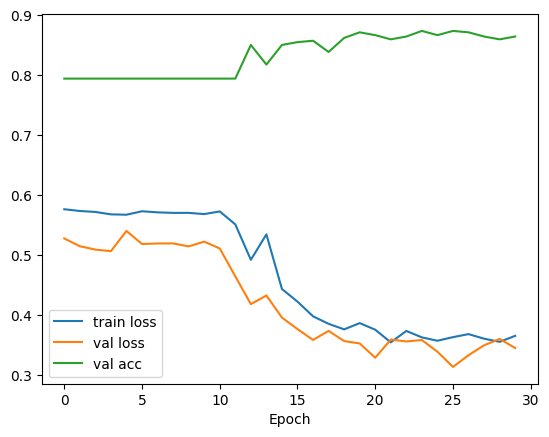

In [15]:
plt.plot(model.losses['train'], label='train loss')
plt.plot(model.losses['val'], label='val loss')
plt.plot(model.losses['val_acc'], label='val acc')
plt.xlabel('Epoch')
plt.legend()
plt.show();

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
       
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA not available")

True
NVIDIA GeForce RTX 2070 SUPER
